# Welcome to digital recognizer with using CNN

**I would really appreciate your votes if you liked this notebook!**

*First we need import all required libraries*

In [1]:
import math
import pandas as pd
import numpy as np
import tensorflow as tf
import h5py
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from keras.datasets import mnist
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model

%matplotlib inline
np.random.seed(2)

# Load the data

In [2]:
# train = pd.read_csv('../input/digit-recognizer/train.csv')
test = pd.read_csv('../input/digit-recognizer/test.csv')

# train.head()

In [3]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


*Here we load and split mnist dataset*

In [4]:
(X_train, Y_train), (X_val, Y_val) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


*Here we look at the examples of inputs*

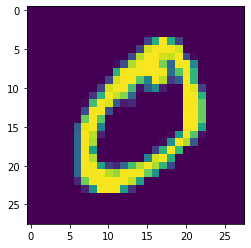

In [5]:
plt.imshow(X_train[1])

# Processing the data

## Data separation

(60000, 28, 28) ,  (60000,)


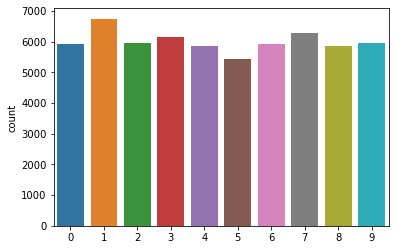

In [6]:
# Y_train = train["label"]
# X_train = train.drop(labels=["label"], axis=1)

print(X_train.shape, ', ', Y_train.shape)

g = sns.countplot(Y_train)

## Data normalization

In [7]:
X_train = X_train/255
test = test/255

print(X_train.shape, ', ', test.shape)

(60000, 28, 28) ,  (28000, 784)


## Data reshaping

*To process the data we need to reshape 784 pixels of each entry into (28, 28, 1)*

In [8]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_val = X_val.reshape(-1, 28, 28, 1)

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
test = test.values.reshape(-1, 28, 28, 1)

print(X_train.shape,', ',X_val.shape,', ', test.shape)

(60000, 28, 28, 1) ,  (10000, 28, 28, 1) ,  (28000, 28, 28, 1)


## Data splitting

In [9]:
#random_seed = 2
Y_train = to_categorical(Y_train, num_classes = 10)

#X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, 
#                                                  random_state = random_seed)
Y_val = to_categorical(Y_val, num_classes = 10)

# Initial model

*This is a model with 11 layers such as convolutional layer, pooling layer, flatten layer and fully-connected(dense) layer. Final layer will make a predictions*

In [10]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = "Same", activation = "relu",
                 kernel_initializer = 'he_uniform', input_shape = (28, 28, 1)))
model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = "Same", activation = "relu",
                kernel_initializer = 'he_uniform'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = "Same", activation = "relu",
                kernel_initializer = 'he_uniform'))
model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = "Same", activation = "relu",
                kernel_initializer = 'he_uniform'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation="relu", kernel_initializer = 'he_uniform'))
model.add(Dropout(0.5))

model.add(Dense(units = 10, activation="softmax", kernel_initializer = 'he_uniform'))

## Compile the model

*We can use different optimizers such as Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl. In this model we use RMSprop optimizer*


In [11]:
optimizer = RMSprop(lr = 0.001, rho = 0.9, epsilon = 1e-08, decay = 0.0)
model.compile(optimizer = optimizer , loss = 'categorical_crossentropy', metrics = ['accuracy'])

*Using the method ```summary()``` we can see layers' types, output shape and amount of parameters*

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0

## Set callbacks

In [13]:
# ModelCheckpoint
checkpoint = ModelCheckpoint('./mod_best.hdf5',monitor = 'val_loss', mode = "min", verbose = 1, save_best_model = True)

# EarlyStopping
earlystop = EarlyStopping(monitor = 'val_loss', patience = 3, min_delta = 0,verbose =1, restore_best_weights = True)

# ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

callbacks = [reduce_lr,checkpoint]

## Data augmentation

*We use data augmentation to prevent overfitting*

In [14]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

## Fit the model

In [15]:
model = load_model("./mod_best.hdf5")

OSError: SavedModel file does not exist at: ./mod_best.hdf5/{saved_model.pbtxt|saved_model.pb}

In [16]:
batch_size = 128
epochs = 30
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size = batch_size),
                              epochs = epochs, validation_data = datagen.flow(X_val,Y_val, batch_size = batch_size),
                              steps_per_epoch = X_train.shape[0] // batch_size,
                              callbacks = callbacks)

Epoch 1/30
468/468 [==============================] - ETA: 0s - loss: 0.3692 - accuracy: 0.8825
Epoch 00001: saving model to ./mod_best.hdf5
468/468 [==============================] - 225s 481ms/step - loss: 0.3692 - accuracy: 0.8825 - val_loss: 6.6664 - val_accuracy: 0.9832
Epoch 2/30
468/468 [==============================] - ETA: 0s - loss: 0.1043 - accuracy: 0.9690
Epoch 00002: saving model to ./mod_best.hdf5
468/468 [==============================] - 226s 482ms/step - loss: 0.1043 - accuracy: 0.9690 - val_loss: 9.5593 - val_accuracy: 0.9833
Epoch 3/30
468/468 [==============================] - ETA: 0s - loss: 0.0805 - accuracy: 0.9763
Epoch 00003: saving model to ./mod_best.hdf5
468/468 [==============================] - 226s 483ms/step - loss: 0.0805 - accuracy: 0.9763 - val_loss: 5.8994 - val_accuracy: 0.9879
Epoch 4/30
468/468 [==============================] - ETA: 0s - loss: 0.0684 - accuracy: 0.9796
Epoch 00004: saving model to ./mod_best.hdf5
468/468 [======================

# Evaluate the model

## Plot the loss and accuracy curves for training and validation

In [17]:
score = model.evaluate(X_val, Y_val, verbose=0)
print("Val_Loss :",score[0])
print("Val_Acc :",score[1])

Val_Loss : 12.091950416564941
Val_Acc : 0.9911999702453613


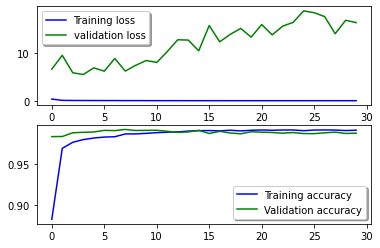

In [18]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(history.history["loss"], color="b", label="Training loss")
ax[0].plot(history.history["val_loss"], color="g", label="validation loss", axes=ax[0])
ax[0].legend(loc="best", shadow=True)

ax[1].plot(history.history["accuracy"], color="b", label="Training accuracy")
ax[1].plot(history.history["val_accuracy"], color="g", label="Validation accuracy")
ax[1].legend(loc="best", shadow=True)

## Confusion matrix

*The function `plot_confusion_matrix()` prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`*

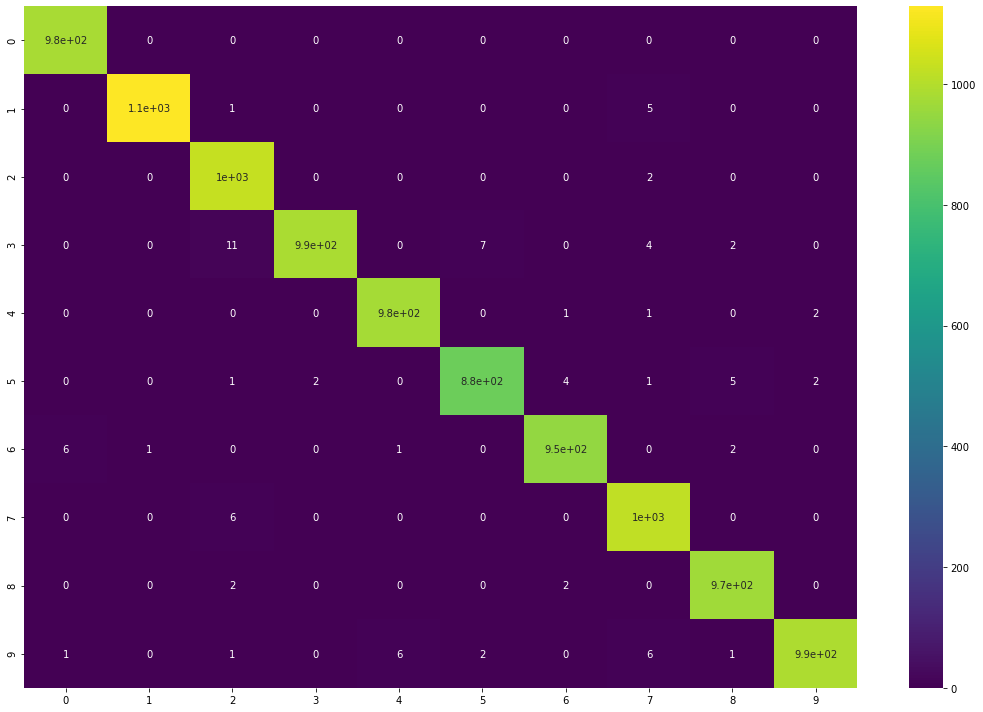

In [19]:
def plot_confusion_matrix(cm, classes, normalize = False, title = "Confusion matrix", cmap = plt.cm.Blues):
    plt.imshow(cm, interpolation = "nearest", cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            cm[i, j],
            horizontalalignment = "center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    
    
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val, axis = 1)
# compute the confusion matrix
CM = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plt.figure(figsize = (15,10))
sns.heatmap(CM,annot = True,cmap = "viridis")
plt.tight_layout()

## Display some error results

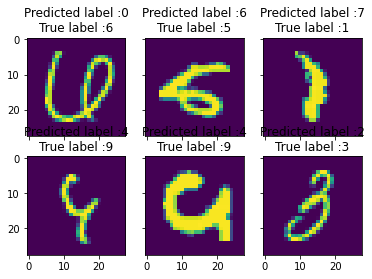

In [20]:


# Errors are difference between predicted labels and true labels
errors = Y_pred_classes - Y_true != 0

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]


def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, sharex = True, sharey = True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row, col].imshow((img_errors[error]).reshape((28, 28)))
            ax[row, col].set_title(
                "Predicted label :{}\nTrue label :{}".format(
                    pred_errors[error], obs_errors[error]
                )
            )
            n += 1


# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors, axis=1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

## Model plotting

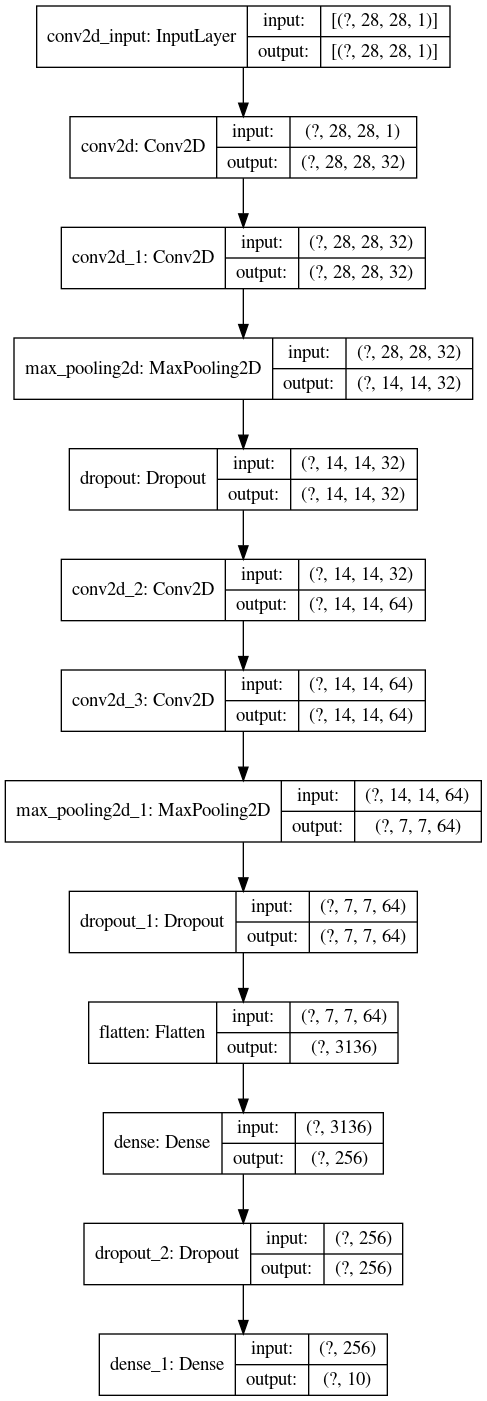

In [21]:
plot_model(model, to_file = "../working/plot.png", show_shapes = True, show_layer_names = True)

## Predictions and accuracy

*Generate predictions on the test data using `predict()`*

In [22]:
probabilities = model.predict(test)
y_pred = np.argmax(probabilities, axis=1)
print(y_pred.shape)

(28000,)


*We evaluate the model on the train data via evaluate()*

# Initial submission

In [23]:
submission = pd.DataFrame({'ImageId': np.arange(1, 28001), 'Label': y_pred})
submission.to_csv("submission.csv", index = False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
